In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
pd.set_option('display.max_colwidth', None)
from collections import Counter


In [3]:
import sklearn
#print('The scikit-learn version is {}.'.format(sklearn.__version__))

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import VarianceThreshold

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, LatentDirichletAllocation


### DEFINE FUNCTIONS

In [4]:
def categorize_offence(offence):
    offence = str(offence)
    offence = offence.lower()
    if ('thef' in offence) or ('larceny' in offence) or ('stolen' in offence):
        offence = "THEFT"
    elif ('fraud' in offence) or ('fortune' in offence) or ('forgery' in offence) or ('gambling' in offence):
        offence = "FRAUD"
    elif ('burglar' in offence) or ('b&e' in offence) or ('break and enter' in offence) or ('unlawfully in' in offence) or ('trespass' in offence):
        offence = "BREAK AND ENTER"
    elif 'robbery' in offence:
        offence = "ROBBERY"
    elif ('assault' in offence) or ('disarming' in offence) or ('death' in offence) or ('off' in offence) or ('touching' in offence):
        offence = "ASSAULT"
    elif ('sex' in offence) or ('rape' in offence):
        offence = "SEX CRIMES"
    elif ('drug' in offence) or ('alcohol' in offence) or ('cannabis' in offence) or ('noxious' in offence):
        offence = "DRINKING/DRUG OFFENSES"
    elif ('homicide' in offence) or ('murder' in offence):
        offence = "MURDER"
    elif ('firearm' in offence) or ('gun' in offence) or ('bodily' in offence) or ('weap' in offence) or ('jostling' in offence):
        offence = "ASSAULT"
    elif 'kidnapping' in offence:
        offence = "KIDNAPPING"
    elif 'loitering' in offence:
        offence = "LOITERING"
    elif ('parking' in offence) or ('traffic' in offence) or ('vehicle' in offence) or ('driving' in offence):
        offence = "PARKING/TRAFFIC/VEHICLE OFFENSES"
    elif ('harassment' in offence) or ('disorderly' in offence) or ('disruption' in offence) or ('harrassment' in offence):
        offence = "DISORDERLY/DISRUPTION/HARASSMENT"
    elif ('child' in offence) or ('abortion' in offence):
        offence = "CHILD CRIMES"
    else:
        offence = 'OTHER'

    return offence

### READ DATASET

In [8]:
#Crimes in Toronto
file_name = 'NYPD_Arrests_Data__Historic__20250524.csv'

#Read dataset
NYPD_Arrests_df = pd.read_csv(file_name)

len(NYPD_Arrests_df) #5,986,025
NYPD_Arrests_df.head()
NYPD_Arrests_df.info()

5986025

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,279197226,12/19/2023,105.0,STRANGULATION 1ST,106.0,FELONY ASSAULT,PL 1211200,F,M,18,0.0,25-44,M,WHITE,988210.0,218129.0,40.765390,-73.985702,POINT (-73.985702 40.76539)
1,278761840,12/09/2023,105.0,STRANGULATION 1ST,106.0,FELONY ASSAULT,PL 1211300,F,K,67,0.0,25-44,M,BLACK,997897.0,175676.0,40.648859,-73.950820,POINT (-73.95082 40.648859)
2,278506761,12/05/2023,153.0,RAPE 3,104.0,RAPE,PL 1302503,F,K,77,0.0,25-44,M,BLACK,1003509.0,185018.0,40.674496,-73.930571,POINT (-73.9305713255961 40.6744956865259)
3,278436408,12/03/2023,157.0,RAPE 1,104.0,RAPE,PL 1303501,F,B,46,0.0,45-64,M,BLACK,1011755.0,250279.0,40.853598,-73.900577,POINT (-73.9005768807295 40.8535983673823)
4,278248753,11/29/2023,660.0,(null),NaN,(null),PL 2407800,M,Q,104,0.0,<18,M,WHITE HISPANIC,1011456.0,194092.0,40.699373,-73.901881,POINT (-73.901881 40.699373)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986025 entries, 0 to 5986024
Data columns (total 19 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ARREST_KEY         int64  
 1   ARREST_DATE        object 
 2   PD_CD              float64
 3   PD_DESC            object 
 4   KY_CD              float64
 5   OFNS_DESC          object 
 6   LAW_CODE           object 
 7   LAW_CAT_CD         object 
 8   ARREST_BORO        object 
 9   ARREST_PRECINCT    int64  
 10  JURISDICTION_CODE  float64
 11  AGE_GROUP          object 
 12  PERP_SEX           object 
 13  PERP_RACE          object 
 14  X_COORD_CD         float64
 15  Y_COORD_CD         float64
 16  Latitude           float64
 17  Longitude          float64
 18  Lon_Lat            object 
dtypes: float64(7), int64(2), object(10)
memory usage: 867.7+ MB


### FEATURE ENGINEERING

In [9]:

#Convert string to datetime
NYPD_Arrests_df["ARREST_DATE"] = pd.to_datetime(NYPD_Arrests_df["ARREST_DATE"])

# Extract the year
NYPD_Arrests_df["CRIME_YEAR"] = NYPD_Arrests_df["ARREST_DATE"].dt.year

#Analysis from 2014 to 2024
NYPD_Arrests_df = NYPD_Arrests_df[NYPD_Arrests_df["CRIME_YEAR"] >= 2014] 

# Extract the month
NYPD_Arrests_df["CRIME_MONTH"] = NYPD_Arrests_df["ARREST_DATE"].dt.month

# Extract the Day of Week
NYPD_Arrests_df["CRIME_DOW"] = NYPD_Arrests_df["ARREST_DATE"].dt.weekday

#Pick the valid age groups
valid_age_group_lst = ['25-44', '18-24', '45-64', '<18', '65+']
len(NYPD_Arrests_df)
NYPD_Arrests_df = NYPD_Arrests_df[NYPD_Arrests_df['AGE_GROUP'].isin(valid_age_group_lst)]
len(NYPD_Arrests_df)

# Define a dictionary for PERP_SEX
sex_mapping = {
    'M': 'Male',
    'F': 'Female',
    'U': 'Undisclosed'
}

# Apply the mapping
NYPD_Arrests_df["PERP_SEX"] = NYPD_Arrests_df["PERP_SEX"].map(sex_mapping)
NYPD_Arrests_df["PERP_SEX"].value_counts(dropna=False)
NYPD_Arrests_df = NYPD_Arrests_df[NYPD_Arrests_df["PERP_SEX"] != 'Undisclosed']
NYPD_Arrests_df["PERP_SEX"].value_counts(dropna=False)


#Law Category Code
# Define a dictionary for LAW_CAT_CD
law_cat_cd_mapping = {
    'F': 'Felony',
    'M': 'Misdemeanor',
    'V': 'Violation',
    'I':'Unclassified Misdemeanors',
    '9':'Resisting/Obstruction'
}

# Apply the mapping
NYPD_Arrests_df["LAW_CAT_CD"].value_counts(dropna=False)
NYPD_Arrests_df["LAW_CAT_CD"] = NYPD_Arrests_df["LAW_CAT_CD"].map(law_cat_cd_mapping)
NYPD_Arrests_df = NYPD_Arrests_df[~NYPD_Arrests_df["LAW_CAT_CD"].isna()]
NYPD_Arrests_df["LAW_CAT_CD"].value_counts(dropna=False)

#Refine the offense type
NYPD_Arrests_df['TYPE_OF_OFFENSE'] = NYPD_Arrests_df['OFNS_DESC'].apply(lambda s: categorize_offence(s))

#pick the offense types of interest
type_of_offense_lst = ['ASSAULT', 'SEX CRIMES', 'BREAK AND ENTER', 'FRAUD', 'PARKING/TRAFFIC/VEHICLE OFFENSES', 
                       'THEFT', 'DRINKING/DRUG OFFENSES', 'MURDER', 'ROBBERY']

NYPD_Arrests_df = NYPD_Arrests_df[NYPD_Arrests_df["TYPE_OF_OFFENSE"].isin(type_of_offense_lst)]

#PERP_RACE
NYPD_Arrests_df = NYPD_Arrests_df[NYPD_Arrests_df["PERP_RACE"] != 'UNKNOWN']

NYPD_Arrests_df.head()


2762745

2762745

PERP_SEX
Male           2278901
Female          480340
Undisclosed       3504
Name: count, dtype: int64

PERP_SEX
Male      2278901
Female     480340
Name: count, dtype: int64

LAW_CAT_CD
M         1682654
F          967450
V           82329
NaN         15883
I            9117
9            1798
(null)         10
Name: count, dtype: int64

LAW_CAT_CD
Misdemeanor                  1682654
Felony                        967450
Violation                      82329
Unclassified Misdemeanors       9117
Resisting/Obstruction           1798
Name: count, dtype: int64

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,...,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat,CRIME_YEAR,CRIME_MONTH,CRIME_DOW,TYPE_OF_OFFENSE
0,279197226,2023-12-19,105.0,STRANGULATION 1ST,106.0,FELONY ASSAULT,PL 1211200,Felony,M,18,...,WHITE,988210.0,218129.0,40.765390,-73.985702,POINT (-73.985702 40.76539),2023,12,1,ASSAULT
1,278761840,2023-12-09,105.0,STRANGULATION 1ST,106.0,FELONY ASSAULT,PL 1211300,Felony,K,67,...,BLACK,997897.0,175676.0,40.648859,-73.950820,POINT (-73.95082 40.648859),2023,12,5,ASSAULT
2,278506761,2023-12-05,153.0,RAPE 3,104.0,RAPE,PL 1302503,Felony,K,77,...,BLACK,1003509.0,185018.0,40.674496,-73.930571,POINT (-73.9305713255961 40.6744956865259),2023,12,1,SEX CRIMES
3,278436408,2023-12-03,157.0,RAPE 1,104.0,RAPE,PL 1303501,Felony,B,46,...,BLACK,1011755.0,250279.0,40.853598,-73.900577,POINT (-73.9005768807295 40.8535983673823),2023,12,6,SEX CRIMES
5,278254593,2023-11-29,464.0,JOSTLING,230.0,JOSTLING,PL 1652501,Misdemeanor,M,18,...,WHITE HISPANIC,990503.0,215519.0,40.758225,-73.977428,POINT (-73.977428 40.758225),2023,11,2,ASSAULT


### INVESTIGATE THE DISTRIBUTION OF CATEGORICAL VARIABLES

In [10]:
ml_col_lst = ['CRIME_YEAR', 'CRIME_MONTH', 'CRIME_DOW','ARREST_BORO', 'ARREST_PRECINCT',
              'JURISDICTION_CODE', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'TYPE_OF_OFFENSE', 'LAW_CAT_CD']

for col in ml_col_lst:
    NYPD_Arrests_df[col].value_counts(dropna=False)


CRIME_YEAR
2014    328913
2015    290637
2016    280972
2017    259441
2024    224527
2018    224438
2023    190662
2019    184569
2022    161940
2021    131859
2020    119646
Name: count, dtype: int64

CRIME_MONTH
3     214696
5     211246
10    209038
1     207715
8     206241
7     200208
4     199238
2     196550
6     196307
9     194128
11    190193
12    172044
Name: count, dtype: int64

CRIME_DOW
2    417172
3    396780
1    376576
4    364381
5    313471
0    279696
6    249528
Name: count, dtype: int64

ARREST_BORO
K    643993
M    620757
B    562395
Q    474371
S     96088
Name: count, dtype: int64

ARREST_PRECINCT
14     81161
40     80008
75     74058
44     71030
52     57141
       ...  
123    11664
111    10172
22      1500
116       91
483        3
Name: count, Length: 79, dtype: int64

JURISDICTION_CODE
0.0     2063914
1.0      160941
2.0      106354
3.0       21586
97.0      15210
72.0       7296
4.0        3384
73.0       2886
6.0        2797
11.0       2588
17.0       2482
15.0       2107
7.0        1577
14.0       1280
69.0        670
71.0        646
87.0        486
12.0        233
9.0         231
88.0        219
51.0        215
16.0        163
13.0        157
85.0         65
52.0         50
74.0         41
79.0         18
76.0          5
8.0           3
Name: count, dtype: int64

AGE_GROUP
25-44    1230510
18-24     538841
45-64     465342
<18       133687
65+        29224
Name: count, dtype: int64

PERP_SEX
Male      1965253
Female     432351
Name: count, dtype: int64

PERP_RACE
BLACK                             1159073
WHITE HISPANIC                     618940
WHITE                              274700
BLACK HISPANIC                     219205
ASIAN / PACIFIC ISLANDER           119317
AMERICAN INDIAN/ALASKAN NATIVE       6369
Name: count, dtype: int64

TYPE_OF_OFFENSE
ASSAULT                             873233
THEFT                               531987
DRINKING/DRUG OFFENSES              349142
PARKING/TRAFFIC/VEHICLE OFFENSES    261594
BREAK AND ENTER                     117229
ROBBERY                             107328
FRAUD                                95622
SEX CRIMES                           47671
MURDER                               13798
Name: count, dtype: int64

LAW_CAT_CD
Misdemeanor                  1609100
Felony                        781497
Unclassified Misdemeanors       6809
Violation                        194
Resisting/Obstruction              4
Name: count, dtype: int64

### SELECT COLUMNS

In [15]:
#Curate the dataset for building the ML classification model
ml_col_lst = ['CRIME_YEAR', 'CRIME_MONTH', 'CRIME_DOW','ARREST_BORO', 'ARREST_PRECINCT',
              'JURISDICTION_CODE', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'TYPE_OF_OFFENSE','LAW_CAT_CD']

NYPD_Arrests_ML_df = NYPD_Arrests_df[ml_col_lst]

#Drop na values
len(NYPD_Arrests_ML_df)
NYPD_Arrests_ML_df = NYPD_Arrests_ML_df.dropna()
len(NYPD_Arrests_ML_df)


NYPD_Arrests_ML_df.head()


2397604

2397604

,CRIME_YEAR,CRIME_MONTH,CRIME_DOW,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,TYPE_OF_OFFENSE,LAW_CAT_CD
0,2023,12,1,M,18,0.0,25-44,Male,WHITE,ASSAULT,Felony
1,2023,12,5,K,67,0.0,25-44,Male,BLACK,ASSAULT,Felony
2,2023,12,1,K,77,0.0,25-44,Male,BLACK,SEX CRIMES,Felony
3,2023,12,6,B,46,0.0,45-64,Male,BLACK,SEX CRIMES,Felony
5,2023,11,2,M,18,0.0,<18,Male,WHITE HISPANIC,ASSAULT,Misdemeanor


### FORMAT THE DATA ACCORDINGLY
- Label Encoder used to convert all strings to numbers

In [16]:
# Initialize the encoder
label_encoder = LabelEncoder()

# Fit and transform
NYPD_Arrests_ML_df["ARREST_BORO"] = label_encoder.fit_transform(NYPD_Arrests_ML_df["ARREST_BORO"].to_list())

NYPD_Arrests_ML_df["AGE_GROUP"] = label_encoder.fit_transform(NYPD_Arrests_ML_df["AGE_GROUP"].to_list())

NYPD_Arrests_ML_df["PERP_SEX"] = label_encoder.fit_transform(NYPD_Arrests_ML_df["PERP_SEX"].to_list())

NYPD_Arrests_ML_df["PERP_RACE"] = label_encoder.fit_transform(NYPD_Arrests_ML_df["PERP_RACE"].to_list())

NYPD_Arrests_ML_df["TYPE_OF_OFFENSE"] = label_encoder.fit_transform(NYPD_Arrests_ML_df["TYPE_OF_OFFENSE"].to_list())

NYPD_Arrests_ML_df["LAW_CAT_CD"] = label_encoder.fit_transform(NYPD_Arrests_ML_df["LAW_CAT_CD"].to_list())

len(NYPD_Arrests_ML_df)
NYPD_Arrests_ML_df.head()
NYPD_Arrests_ML_df.to_csv("NYPD_Arrests_ML_df.csv")

2397604

,CRIME_YEAR,CRIME_MONTH,CRIME_DOW,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,TYPE_OF_OFFENSE,LAW_CAT_CD
0,2023,12,1,2,18,0.0,1,1,4,0,0
1,2023,12,5,1,67,0.0,1,1,2,0,0
2,2023,12,1,1,77,0.0,1,1,2,7,0
3,2023,12,6,0,46,0.0,2,1,2,7,0
5,2023,11,2,2,18,0.0,4,1,5,0,1


### SPLIT DATA INTO TRAIN AND TEST
- predict the sex of the perpetrator

In [17]:
col_lst = ['CRIME_YEAR', 'CRIME_MONTH', 'CRIME_DOW','ARREST_BORO', 'ARREST_PRECINCT',
              'JURISDICTION_CODE', 'AGE_GROUP', 'TYPE_OF_OFFENSE', 'PERP_RACE', 'LAW_CAT_CD']

X = NYPD_Arrests_ML_df[col_lst]
y = NYPD_Arrests_ML_df['PERP_SEX']

#Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.head(2)
X_test.head(2)
y_train.head(2)
y_test.head(2)

,CRIME_YEAR,CRIME_MONTH,CRIME_DOW,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,TYPE_OF_OFFENSE,PERP_RACE,LAW_CAT_CD
112833,2023,7,3,0,46,0.0,0,8,2,0
618664,2020,7,4,1,77,0.0,0,0,2,0


,CRIME_YEAR,CRIME_MONTH,CRIME_DOW,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,TYPE_OF_OFFENSE,PERP_RACE,LAW_CAT_CD
667737,2020,4,3,4,123,0.0,1,0,5,1
587401,2020,12,2,3,105,0.0,1,5,2,1


112833    1
618664    1
Name: PERP_SEX, dtype: int64

667737    1
587401    1
Name: PERP_SEX, dtype: int64

### HANDLE IMBALANCED DATASET
- oversampler

In [18]:
#Distribution of offense type in training set
value_counts = Counter(y_train)
value_counts

Counter({1: 1375802, 0: 302520})

In [19]:
#Distribution of offense type in test set
value_counts = Counter(y_test)
value_counts

Counter({1: 589451, 0: 129831})

In [20]:
#Oversampling to handle imbalance in train set
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

print("X Resampled")
X_resampled.shape
X_resampled.head()

print("\n y Resampled")
y_resampled.shape
y_resampled.head()

#Distribution
value_counts = Counter(y_resampled)
value_counts


X Resampled


(2751604, 10)

,CRIME_YEAR,CRIME_MONTH,CRIME_DOW,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,TYPE_OF_OFFENSE,PERP_RACE,LAW_CAT_CD
0,2023,7,3,0,46,0.0,0,8,2,0
1,2020,7,4,1,77,0.0,0,0,2,0
2,2022,6,2,3,105,0.0,2,0,2,1
3,2016,10,4,2,25,0.0,2,2,2,1
4,2016,4,3,0,40,0.0,1,8,2,1



 y Resampled


(2751604,)

0    1
1    1
2    1
3    1
4    1
Name: PERP_SEX, dtype: int64

Counter({1: 1375802, 0: 1375802})

### STRATIFIED SAMPLING
- PERP_SEX

In [21]:
col_lst = ['CRIME_YEAR', 'CRIME_MONTH', 'CRIME_DOW','ARREST_BORO', 'ARREST_PRECINCT',
              'JURISDICTION_CODE', 'AGE_GROUP', 'TYPE_OF_OFFENSE', 'PERP_RACE', 'LAW_CAT_CD']

#stratified sampling based on TYPE_OF_OFFENSE
X_resampled['PERP_SEX'] = list(y_resampled)

sampling_fraction = 0.01

X_resampled = X_resampled.groupby('PERP_SEX', group_keys=False).apply(lambda x: x.sample(frac=sampling_fraction)).reset_index(drop=True)
y_resampled = X_resampled['PERP_SEX']
X_resampled = X_resampled[col_lst]

#Distribution
value_counts = Counter(y_resampled)
value_counts


C:\Users\Vanessa\AppData\Local\Temp\ipykernel_4400\3831781.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X_resampled = X_resampled.groupby('PERP_SEX', group_keys=False).apply(lambda x: x.sample(frac=sampling_fraction)).reset_index(drop=True)


Counter({0: 13758, 1: 13758})

### TRAIN THE MODEL
- Predict PERP_SEX
- Experiment with different ML classification models
- Pick the model with the highest F1 score
- Classification Metrics
    - Accuracy
    - Precision
    - Recall
    - F1 Score
    - ROC
    - Log Loss
    - Cohen Kappa
    - Confusion Matric
    - Variable Importance Factor

In [22]:
classification_models = []
classification_models.append(("Decision Tree", DecisionTreeClassifier(random_state=42, criterion="entropy", min_samples_split=10, min_samples_leaf=10, max_depth=3, max_leaf_nodes=5)))
classification_models.append(("Decision Tree 2",DecisionTreeClassifier(max_depth=2)))
classification_models.append(("Naive Bayes", GaussianNB()))
classification_models.append(("KNN Classifier", KNeighborsClassifier()))
classification_models.append(("SVM Classifier", LinearSVC()))
classification_models.append(("Logistic Regression", LogisticRegression(max_iter=1000)))
classification_models.append(("Random Forest Classifier", RandomForestClassifier(max_depth=2,random_state=42)))
classification_models.append(("Ada Boost", AdaBoostClassifier(base_estimator=(DecisionTreeClassifier(random_state=42, criterion="entropy", min_samples_split=10, min_samples_leaf=10, max_depth=3, max_leaf_nodes=5)),n_estimators=100,random_state=42)))
classification_models.append(("XGBBoost", XGBClassifier(n_estimators = 100, max_depth=3)))

f1_score_lst = []
cohen_kappa_score_lst = []
log_loss_lst = []
accuracy_score_lst = []
precision_score_lst = []
recall_score_lst = []
roc_auc_score_lst = []
name_lst = []


for name, model in classification_models:
    name_lst.append(name)
    
    # Train the model
    model.fit(X_resampled, y_resampled)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate
    f1_score_lst.append(f1_score(y_test, y_pred))
    cohen_kappa_score_lst.append(cohen_kappa_score(y_test, y_pred))
    log_loss_lst.append(log_loss(y_test, y_pred))
    accuracy_score_lst.append(accuracy_score(y_test, y_pred))
    precision_score_lst.append(precision_score(y_test, y_pred))
    recall_score_lst.append(recall_score(y_test, y_pred))
    roc_auc_score_lst.append(roc_auc_score(y_test, y_pred))

    


metrics_df = pd.DataFrame({'model_name':name_lst,
                           'f1_score':f1_score_lst,
                           'accuracy_score':accuracy_score_lst,
                           'cohen_kappa_score':cohen_kappa_score_lst,
                           'log_loss':log_loss_lst,
                           'precision_score':precision_score_lst,
                           'recall_score':recall_score_lst,
                           'roc_auc_score':roc_auc_score_lst
                          })


metrics_df.sort_values(by=["f1_score"], ascending=False)

DecisionTreeClassifier(criterion='entropy', max_depth=3, max_leaf_nodes=5,
                       min_samples_leaf=10, min_samples_split=10,
                       random_state=42)

DecisionTreeClassifier(max_depth=2)

GaussianNB()

KNeighborsClassifier()

C:\Users\Vanessa\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

C:\Users\Vanessa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LogisticRegression(max_iter=1000)

RandomForestClassifier(max_depth=2, random_state=42)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=3,
                                                         max_leaf_nodes=5,
                                                         min_samples_leaf=10,
                                                         min_samples_split=10,
                                                         random_state=42),
                   n_estimators=100, random_state=42)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

,model_name,f1_score,accuracy_score,cohen_kappa_score,log_loss,precision_score,recall_score,roc_auc_score
6,Random Forest Classifier,0.717120,0.600130,0.090980,13.811076,0.853183,0.618486,0.567640
7,Ada Boost,0.694741,0.584431,0.121883,14.353285,0.872724,0.577056,0.597487
8,XGBBoost,0.690931,0.582188,0.128344,14.430784,0.877281,0.569879,0.603974
2,Naive Bayes,0.626712,0.515667,0.057850,16.728326,0.850608,0.496123,0.550262
0,Decision Tree,0.624318,0.522848,0.102370,16.480297,0.879882,0.483798,0.591969
3,KNN Classifier,0.605236,0.495978,0.044155,17.408362,0.844958,0.471474,0.539351
1,Decision Tree 2,0.571022,0.479232,0.082236,17.986725,0.878645,0.422944,0.578865
5,Logistic Regression,0.524212,0.431142,0.017797,19.647694,0.833201,0.382400,0.517420
4,SVM Classifier,0.000000,0.180501,0.000000,28.304498,0.000000,0.000000,0.500000


### HYPERPARAMETER TUNING

In [23]:
#Get the best combination of parameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5)
grid_search.fit(X_resampled, y_resampled)

print("Best Parameters:", grid_search.best_params_)
print("Best Estimator:", grid_search.best_estimator_)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]})

Best Parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Estimator: RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=2)


### FEATURE IMPORTANCE

In [ ]:
forest = RandomForestClassifier(bootstrap=False, 
                                max_depth=10, 
                                min_samples_leaf=2, 
                                min_samples_split=2, 
                                n_estimators = 100)


RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=2)

<AxesSubplot:>

Text(0.5, 1.0, 'Feature importances using MDI')

Text(0, 0.5, 'Mean decrease in impurity')

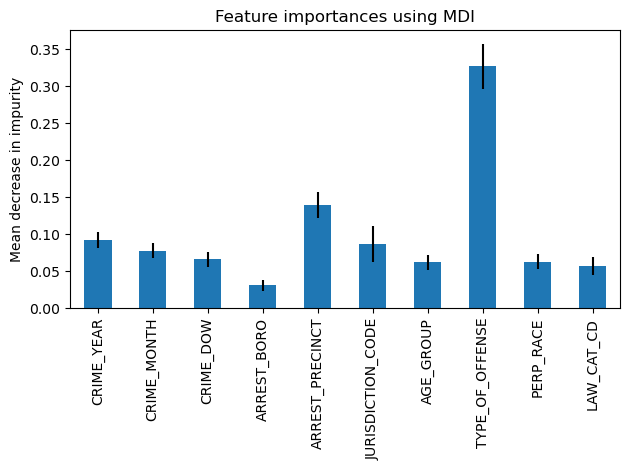

In [36]:
forest = RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=2)

# Train the model
forest.fit(X_resampled, y_resampled)

#feature importances
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
feature_names = forest.feature_names_in_


#Draw the feature importances
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### CLASSIFICATION REPORT AND CONFUSION MATRIX

In [37]:
# Predict
y_pred = forest.predict(X_test)

# Evaluate
print('Classification Report - Random Forest Classifier: \n\n',classification_report(y_test, y_pred))
print('\n Confusion Matrix - Random Forest Classifier: \n',confusion_matrix(y_test, y_pred))


Classification Report - Random Forest Classifier: 

               precision    recall  f1-score   support

           0       0.25      0.64      0.35    129831
           1       0.88      0.56      0.69    589451

    accuracy                           0.58    719282
   macro avg       0.56      0.60      0.52    719282
weighted avg       0.76      0.58      0.63    719282


 Confusion Matrix - Random Forest Classifier: 
 [[ 83319  46512]
 [256515 332936]]


### ROC CURVE

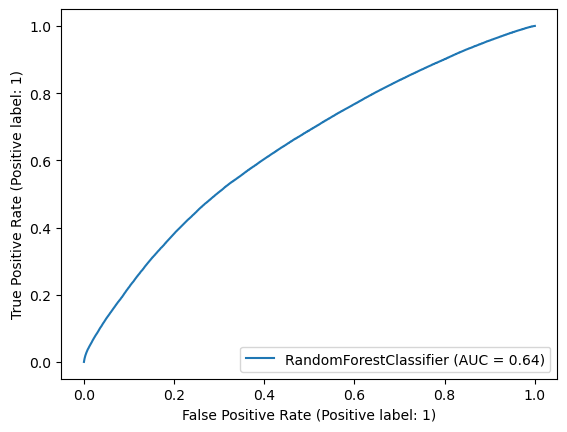

In [38]:
forest_disp = RocCurveDisplay.from_estimator(forest, X_test, y_test)
plt.show()